In [64]:
import pandas as pd
import numpy as np
import math
import glob
import scipy
import os.path as op
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf

#r stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 
lme4 = importr("lme4")

%matplotlib inline

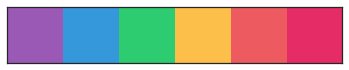

In [65]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

In [2]:
# get list of data files to process
data_files = glob.glob('data/*txt')

In [3]:
# CONSTANTS NECESSARY FOR MAKING SENSE OF THE DATA FILES
col_names = ['stim', 'cond', 'trial', 'amountSS',
             'amountLL', 'delayLL', 'choice', 'space','pct_diff']
stim = { 1:'Pre', 2:'TMS', 3:'Sham' }
cond = { 1:'Ctrl', 2:'Hidden Zero', 3:'Magnitude' }
choice = { 1:'SS', 0:'LL'}

In [4]:
all_data = []
for f in data_files:
    data = pd.read_csv(f, delimiter = '\t', header = None,
                      names = col_names, index_col = False)
    
    data['choice_binary'] = data['choice']
    data['choice'] = [choice[x] for x in data['choice']]
    data['cond'] = [cond[x] for x in data['cond']]
    data['stim'] = [stim[x] for x in data['stim']]
    
    data = data[['stim', 'cond', 'trial', 'amountSS', 
                 'amountLL', 'delayLL', 'choice','choice_binary','pct_diff']]
    
    data['hemi'] = f.split('/')[1].split('s')[0]
    data['sub'] = f.split('.')[0][-2:]
     
    all_data.append(data)
all_data = pd.concat(all_data)

In [5]:
def find_K(A1,A2,d1,d2):
    return (A2/A1 - 1)*1.0 / (d2 - (A2/A1)*d1)

In [6]:
#find k_eq for each choice
for row in set(all_data.index):
    k_eq = find_K(all_data.loc[row,'amountSS'].values[0],
       all_data.loc[row,'amountLL'].values[0],
       0,
       all_data.loc[row,'delayLL'].values[0])
    

    all_data.loc[row,'k_eq'] = k_eq

#drop trial level
all_data = all_data.reset_index().set_index(['sub','cond','stim','hemi']).sort_index()

In [7]:
def hyperbolic(A,d,k):
    return A * 1.0/(1.0+k*d)

In [8]:
def errf(params,sub_data):
    #get params and bound on [0,1]
    k,m = params
    k = scipy.stats.logistic.cdf(k)
    m = scipy.stats.logistic.cdf(m)*20
    LL = 0
    for trial in range(sub_data.shape[0]):
        SV_SS = hyperbolic(sub_data.loc[trial,'amountSS'],
                            0, #delayed rewards available now
                            k)
        SV_LL = hyperbolic(sub_data.loc[trial,'amountLL'],
                            sub_data.loc[trial,'delayLL'],
                            k)

        p = 1 / (1 + np.exp(-1*(SV_SS-SV_LL)*m) )
        if sub_data.loc[trial,'choice'] == 'LL':
            p = 1-p
            
        if p < 1e-100:
            p = 1e-100
            
        LL += np.log(p)
    return LL*-1 #minimize negative log likelihood

In [9]:
in_tuples = list(set(all_data.index))

In [10]:
def run_data(in_tup):
    #get the data for this experiment
    sub_data = all_data.loc[in_tup].reset_index().copy()
    sub, exp, tms, hemi = in_tup
    
    #check to see if they made all LL or all SS choices and set k appropriately
    if sum(sub_data['choice'] == 'LL') == sub_data.shape[0]: #all larger later
        k = min(sub_data['k_eq'])
        return in_tup,k
    elif sum(sub_data['choice'] == 'SS') == sub_data.shape[0]: #all SS
        k = max(sub_data['k_eq'])
        return in_tup,k
    
    #run minimization
    else:
        k_init = scipy.stats.logistic.ppf(all_data.median()['k_eq'])
        m_init = -5
        if exp == 'Magnitude':
            m_init = scipy.stats.logistic.cdf(m_init)/10.0
            m_init = scipy.stats.logistic.ppf(m_init)
        params = [k_init,m_init]
        minimizer_kwargs = {"method": 'CG', 'args':(sub_data)}
        try:
            res = basinhopping(errf, params, minimizer_kwargs=minimizer_kwargs,niter=50)
        except:
            return (in_tup,'Failed')
        return (in_tup,res)

# If running fits, execute the next two cells

In [11]:
# pool = multiprocessing.Pool(54)
# res = pool.map(run_data,in_tuples)
# pool.terminate()
# pool.join()

In [12]:
# results_df = {'ll':[], 'k':[], 'm':[],'sub':[],'exp':[],'hemi':[],'tms':[]}
# for x in res:
#     in_tup,o = x
#     sub, exp, tms, hemi = in_tup
#     if o == 'Failed':
#         print in_tup
        
#     else:
#         results_df['ll'].append(o.fun*-1)
#         results_df['k'].append(scipy.stats.logistic.cdf(o.x[0]))
#         results_df['m'].append(scipy.stats.logistic.cdf(o.x[1])*20)
#         results_df['sub'].append(sub)
#         results_df['exp'].append(exp)
#         results_df['tms'].append(tms)
#         results_df['hemi'].append(hemi)
# results_df = pd.DataFrame(results_df)
# results_df['logk'] = np.log(results_df['k'])
# results_df.to_csv(op.abspath('./k_fits_new.csv'), index = False)
# results_df = results_df.set_index(['sub','exp','tms','hemi'])

# Analyze Data

In [9]:
#load data
results_df = pd.read_csv(op.abspath('./k_fits_new.csv'))
results_df['logk'] = np.log(results_df['k'])
results_df['sub_id'] = [str(x) + y for x,y in zip(results_df['sub'],results_df['hemi'])]
# results_df = results_df.set_index(['sub','exp','tms','hemi'])


In [11]:
# for row in set(all_data.index):
#     sub, exp, tms, hemi = row
    
#     best_k = results_df.loc[(int(sub),exp,tms,hemi),'k']
#     min_k = min(all_data.loc[row,'k_eq'])
#     max_k = max(all_data.loc[row,'k_eq'])

#     if best_k < min_k:
#         results_df.loc[(int(sub),exp,tms,hemi),'k'] = min_k
#     if best_k > max_k:
#         results_df.loc[(int(sub),exp,tms,hemi),'k'] = max_k
results_df = results_df.reset_index()
results_df['logk'] = np.log(results_df['k'])

## First check out all the data

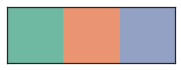

In [41]:
def remove_intercept_variance(x, group_mean):
    return x - x.mean() + group_mean
sns.choose_colorbrewer_palette('q')

In [13]:
results_df['logk_within'] = results_df.groupby('sub_id').logk.transform(remove_intercept_variance,
                                                                  results_df.logk.mean())

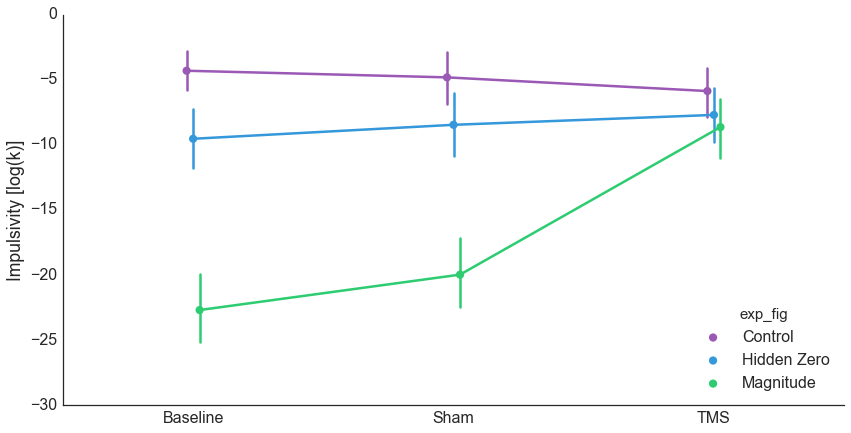

In [66]:
tms_map = {'Pre':'Baseline', 'Sham':'Sham', 'TMS':'TMS'}
results_df['tms_fig'] = [tms_map[x] for x in results_df['tms']]
exp_map = {'Ctrl':'Control', 'Hidden Zero':'Hidden Zero', 'Magnitude':'Magnitude'}
results_df['exp_fig'] = [exp_map[x] for x in results_df['exp']]

sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
sns.set_style("white")
sns.pointplot(x = 'tms_fig',
            y = 'logk_within',
            hue = 'exp_fig',
            order = ['Baseline','Sham','TMS'], 
            data = results_df,
               dodge = .05,
              palette = flatui,
              kwargs = {'error_kw':dict(ecolor='grey')})
sns.despine()
plt.ylabel('Impulsivity [log(k)]')
plt.xlabel('')
plt.savefig(op.abspath('./figs/all_conds.png'), dpi = 300)

### Next see if any effects vary by hemisphere

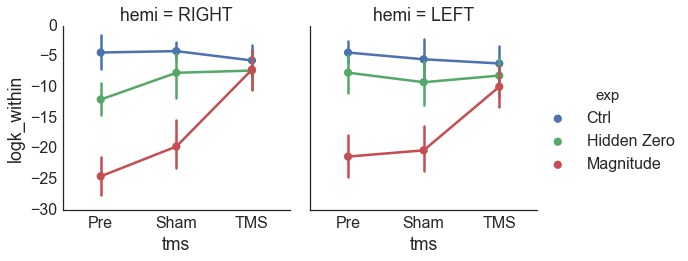

In [471]:
sns.factorplot(x = 'tms',
               y = 'logk_within',
               hue = 'exp',
               col = 'hemi',
               order = ['Pre','Sham','TMS'],
               data = results_df)

## Check out Magnitude Effect

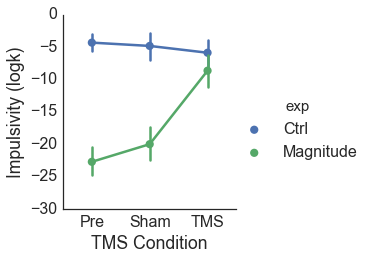

In [543]:
mag = results_df[results_df['exp'] != 'Hidden Zero'].copy()
mag['logk_within'] = mag.groupby('sub_id').logk.transform(remove_intercept_variance,
                                                                  mag.logk.mean())
mag['TMS Condition'] = mag['tms']
sns.factorplot(x = 'TMS Condition',
            y = 'logk_within',
            hue = 'exp' ,
            order = ['Pre','Sham','TMS'],
            data = mag)
plt.ylabel('Impulsivity (logk)')
sns.despine()
plt.savefig(op.abspath('./figs/Magnitude.png'), dpi = 300)

### First assess whether the effect is significant when comparing to sham

In [473]:
sham = mag[mag['tms'] !='Pre']

In [474]:
model = afex.aov_ez('sub_id', 'logk', data = sham, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE         F   ges p.value
1         hemi 1, 25 85.17      0.35  .005     .56
2          exp 1, 25 48.45 43.75 ***   .27  <.0001
3     hemi:exp 1, 25 48.45      0.09 .0007     .77
4          tms 1, 25 74.71   9.57 **   .11    .005
5     hemi:tms 1, 25 74.71      0.04 .0005     .85
6      exp:tms 1, 25 21.30 49.27 ***   .15  <.0001
7 hemi:exp:tms 1, 25 21.30      0.71  .003     .41

Sphericity correction method: GG 



In [475]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = sham.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','RIGHT')]
a = ctrl.loc['Sham'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','right', scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','LEFT')]
a = ctrl.loc['Sham'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','left', scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['exp','tms']).sort_index().loc[('Ctrl')]
a = ctrl.loc['Sham'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','both', scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['tms','exp']).sort_index().loc[('Sham')]
a = ctrl.loc['Magnitude'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'mag',scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['tms','exp']).sort_index().loc[('TMS')]
a = ctrl.loc['Magnitude'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'mag tms',scipy.stats.ttest_rel(a,b)

tms right Ttest_relResult(statistic=1.3567303443801471, pvalue=0.20205651181755452)
tms left Ttest_relResult(statistic=0.257798958951104, pvalue=0.80031291107642921)
tms both Ttest_relResult(statistic=0.69306846180328108, pvalue=0.4944116043253961)
mag Ttest_relResult(statistic=-7.8842386145200054, pvalue=2.3223345130670767e-08)
mag tms Ttest_relResult(statistic=-2.4004197109644783, pvalue=0.02382814250063945)


In [476]:
ks = sham.groupby(['exp','tms']).median()['logk']
ks

exp        tms 
Ctrl       Sham    -3.775735
           TMS     -2.468029
Magnitude  Sham   -22.265795
           TMS     -6.122893
Name: logk, dtype: float64

In [477]:
k = ks.loc[('Ctrl','Sham')]
print 20*(1+np.exp(k)*14)
k = ks.loc[('Magnitude','Sham')]
print 2000*(1+np.exp(k)*14)
k = ks.loc[('Ctrl','TMS')]
print 20*(1+np.exp(k)*14)
k = ks.loc[('Magnitude','TMS')]
print 2000*(1+np.exp(k)*14)
print (26-20.0)/20.0

26.4176688078
2000.00000599
43.7304868926
2061.37896806
0.3


In [478]:
min(all_data.loc[(row),'k_eq'])

3.571428571428178e-05

## Next assess the effect relative to the pre-test

In [479]:
pre = mag[mag['tms'] !='Sham']

In [480]:
model = afex.aov_ez('sub_id', 'logk', data = pre, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE          F   ges p.value
1         hemi 1, 25 77.20       0.02 .0003     .89
2          exp 1, 25 17.46 171.66 ***   .39  <.0001
3     hemi:exp 1, 25 17.46       0.08 .0003     .78
4          tms 1, 25 71.04  15.50 ***   .19   .0006
5     hemi:tms 1, 25 71.04       0.98   .01     .33
6      exp:tms 1, 25 18.70  90.35 ***   .27  <.0001
7 hemi:exp:tms 1, 25 18.70       2.71   .01     .11

Sphericity correction method: GG 



In [481]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = pre.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','RIGHT')]
a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','right', scipy.stats.ttest_rel(a,b)

ctrl = pre.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','LEFT')]
a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','left', scipy.stats.ttest_rel(a,b)

ctrl = pre.set_index(['exp','tms']).sort_index().loc[('Ctrl')]
a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','both', scipy.stats.ttest_rel(a,b)

ctrl = pre.set_index(['tms','exp']).sort_index().loc[('Pre')]
a = ctrl.loc['Magnitude'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'mag',scipy.stats.ttest_rel(a,b)

tms right Ttest_relResult(statistic=0.55447680614333483, pvalue=0.59034775010739027)
tms left Ttest_relResult(statistic=0.78202917517071024, pvalue=0.44722271069611585)
tms both Ttest_relResult(statistic=0.97434837792964313, pvalue=0.3388622461016999)
mag Ttest_relResult(statistic=-15.574204435069051, pvalue=1.0664619779333989e-14)


## Check out Hidden Zero effect

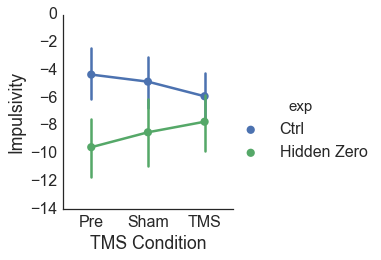

In [489]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (7, 8)})
sns.set_style("white")
hz = results_df[results_df['exp'] != 'Magnitude'].copy()
hz['logk_within'] = hz.groupby('sub_id').logk.transform(remove_intercept_variance,
                                                                  hz.logk.mean())
hz['TMS Condition'] = hz['tms']
sns.factorplot(x = 'TMS Condition',
            y = 'logk_within',
            hue = 'exp' ,
            order = ['Pre','Sham','TMS'],
            data = hz)
plt.ylabel('Impulsivity')
sns.despine()
plt.savefig(op.abspath('../fd/figs/committee_meeting/Hidden_Zero.png'), dpi = 300)

### First assess whether the effect is significant when comparing to sham

In [483]:
sham = hz[hz['tms'] !='Pre']

In [484]:
model = afex.aov_ez('sub_id', 'logk', data = sham, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df    MSE      F    ges p.value
1         hemi 1, 25 141.09   0.12   .003     .73
2          exp 1, 25  28.25 7.00 *    .03     .01
3     hemi:exp 1, 25  28.25   0.02 <.0001     .90
4          tms 1, 25  59.10   0.02  .0001     .90
5     hemi:tms 1, 25  59.10   0.07  .0006     .79
6      exp:tms 1, 25  28.55   0.77   .003     .39
7 hemi:exp:tms 1, 25  28.55   0.00 <.0001     .98

Sphericity correction method: GG 



In [485]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = sham.set_index(['tms','exp']).sort_index().loc[('Sham')]
a = ctrl.loc['Hidden Zero'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'hidden zero',scipy.stats.ttest_rel(a,b)

hidden zero Ttest_relResult(statistic=-1.9379668985442868, pvalue=0.063558773528699042)


### Next assess the effect relative to the pre-test

In [486]:
pre = hz[hz['tms'] !='Sham']

In [487]:
model = afex.aov_ez('sub_id', 'logk', data = pre, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df    MSE         F   ges p.value
1         hemi 1, 25 122.35      0.22  .005     .64
2          exp 1, 25  18.80 18.82 ***   .06   .0002
3     hemi:exp 1, 25  18.80      1.46  .005     .24
4          tms 1, 25  55.34      0.04 .0004     .84
5     hemi:tms 1, 25  55.34      0.97  .010     .33
6      exp:tms 1, 25  17.36    5.13 *   .02     .03
7 hemi:exp:tms 1, 25  17.36      2.13  .007     .16

Sphericity correction method: GG 



In [488]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = pre.set_index(['tms','exp']).sort_index().loc[('Pre')]
a = ctrl.loc['Hidden Zero'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'hidden zero',scipy.stats.ttest_rel(a,b)

hidden zero Ttest_relResult(statistic=-3.4857239699456009, pvalue=0.0017588251875621996)


# Next directly compare HZ and Magnitude

In [58]:
#subtract out control conditions in order to directly compare effects
sham = results_df[results_df['tms'] !='Pre'].set_index(['exp','tms','sub_id']).sort_index().copy()

sham.loc[('Magnitude','TMS'),'logk'] = (sham.loc[('Magnitude','TMS'),'logk'] - sham.loc[('Ctrl','TMS'),'logk']).values
sham.loc[('Magnitude','Sham'),'logk'] = (sham.loc[('Magnitude','Sham'),'logk'] - sham.loc[('Ctrl','Sham'),'logk']).values
sham.loc[('Hidden Zero','TMS'),'logk'] = (sham.loc[('Hidden Zero','TMS'),'logk'] - sham.loc[('Ctrl','TMS'),'logk']).values
sham.loc[('Hidden Zero','Sham'),'logk'] = (sham.loc[('Hidden Zero','Sham'),'logk'] - sham.loc[('Ctrl','Sham'),'logk']).values

sham = sham.reset_index()
sham = sham[sham['exp'] != 'Ctrl']
sham['logk'] = sham['logk']*-1

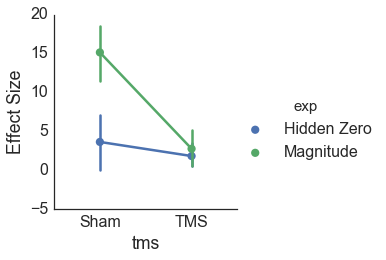

In [549]:
sns.factorplot(x = 'tms',
            y = 'logk',
            hue = 'exp',
            order = ['Sham','TMS'], 
            data = sham)
sns.despine()
plt.ylabel('Effect Size')

In [531]:
model = afex.aov_ez('sub_id', 'logk', data = sham, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df    MSE         F   ges p.value
1         hemi 1, 25 119.48      0.06  .001     .80
2          exp 1, 25  33.91 30.15 ***   .14  <.0001
3     hemi:exp 1, 25  33.91      0.05 .0003     .82
4          tms 1, 25  81.37 16.91 ***   .18   .0004
5     hemi:tms 1, 25  81.37      0.20  .003     .66
6      exp:tms 1, 25  18.33 41.86 ***   .11  <.0001
7 hemi:exp:tms 1, 25  18.33      0.76  .002     .39

Sphericity correction method: GG 



In [541]:
# ctrl = sham.set_index(['exp','tms']).sort_index().loc[('Ctrl')]
# a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
# b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
# print 'tms','both', scipy.stats.ttest_rel(a,b)
s = sham.set_index(['exp','tms']).sort_index()

interaction = s.loc[('Magnitude',"TMS")].sort_values(by = 'sub_id')['logk'].values -\
s.loc[('Magnitude',"Sham")].sort_values(by = 'sub_id')['logk'].values -\
s.loc[('Hidden Zero',"TMS")].sort_values(by = 'sub_id')['logk'].values +\
s.loc[('Hidden Zero',"Sham")].sort_values(by = 'sub_id')['logk'].values 



array([  2.06322084, -18.43058008, -15.84952087,  -8.0890743 ,
        -9.1805613 , -19.75500728, -27.54123829, -14.38258116,
         0.36872538,  -5.8783645 ,  -1.24819227,  -2.63376702,
        -2.51640532,  -4.34312293, -23.27764333, -15.91885369,
       -17.90385551, -11.47403308, -20.84988253,  -2.86257684,
        -5.91036049, -17.19415564,  -3.04218538, -18.8929484 ,
         1.88872482,  -4.48634626, -18.03473225])

In [59]:
#subtract out control conditions in order to directly compare effects
pre = results_df[results_df['tms'] !='Sham'].set_index(['exp','tms','sub_id']).sort_index().copy()

pre.loc[('Magnitude','TMS'),'logk'] = (pre.loc[('Magnitude','TMS'),'logk'] - pre.loc[('Ctrl','TMS'),'logk']).values
pre.loc[('Magnitude','Pre'),'logk'] = (pre.loc[('Magnitude','Pre'),'logk'] - pre.loc[('Ctrl','Pre'),'logk']).values
pre.loc[('Hidden Zero','TMS'),'logk'] = (pre.loc[('Hidden Zero','TMS'),'logk'] - pre.loc[('Ctrl','TMS'),'logk']).values
pre.loc[('Hidden Zero','Pre'),'logk'] = (pre.loc[('Hidden Zero','Pre'),'logk'] - pre.loc[('Ctrl','Pre'),'logk']).values

pre = pre.reset_index()
pre = pre[pre['exp'] != 'Ctrl']
pre['logk'] = pre['logk']*-1

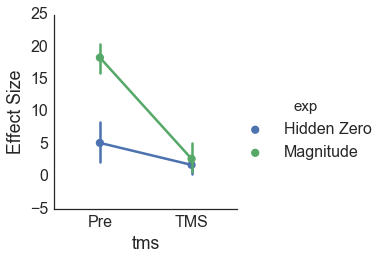

In [528]:
sns.factorplot(x = 'tms',
            y = 'logk',
            hue = 'exp',
            order = ['Pre','TMS'], 
            data = pre)
sns.despine()
plt.ylabel('Effect Size')

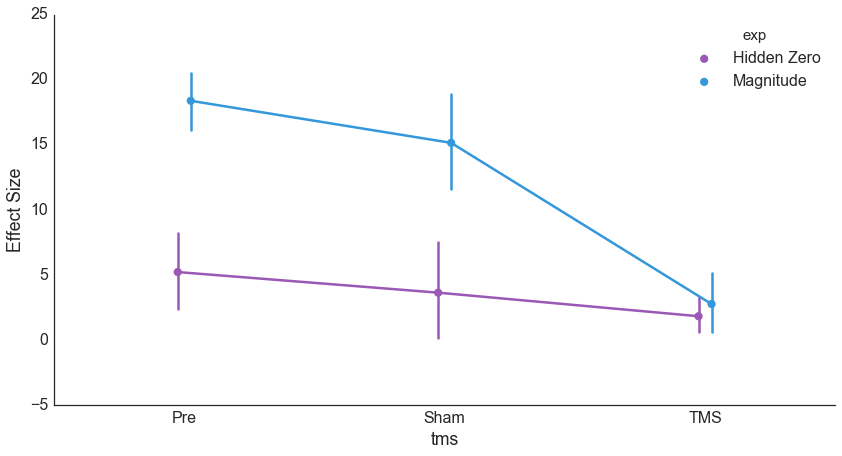

In [67]:
s = sham[sham['tms'] == 'Sham']
fig_df = pd.concat([s,pre])
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
sns.pointplot(x = 'tms',
            y = 'logk',
            hue = 'exp',
            dodge = .05,
            order = ['Pre','Sham','TMS'], 
            palette = flatui,
            data = fig_df)
sns.despine()
plt.ylabel('Effect Size')
plt.savefig(op.abspath('./figs/effect.png'), dpi = 300)



In [513]:
model = afex.aov_ez('sub_id', 'logk', data = pre, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE         F   ges p.value
1         hemi 1, 25 33.11      1.25   .01     .27
2          exp 1, 25 39.40 32.77 ***   .26  <.0001
3     hemi:exp 1, 25 39.40      0.41  .004     .53
4          tms 1, 25 40.19 63.55 ***   .41  <.0001
5     hemi:tms 1, 25 40.19    4.34 *   .05     .05
6      exp:tms 1, 25 31.93 31.40 ***   .22  <.0001
7 hemi:exp:tms 1, 25 31.93      0.03 .0003     .86

Sphericity correction method: GG 



# Percent SS Analysis

In [82]:
perc_df =all_data.reset_index().groupby(['sub','stim','cond','hemi']).mean().reset_index()
perc_df['sub_id'] = [str(x) + y for x,y in zip(perc_df['sub'],perc_df['hemi'])]
perc_df['choice_binary_logit'] = [scipy.special.logit(x) for x in perc_df['choice_binary']]

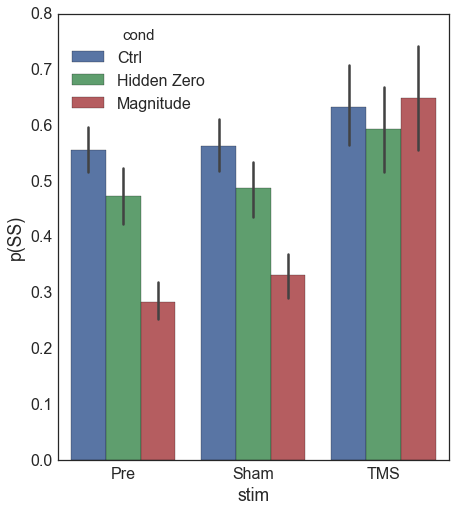

In [83]:
sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = perc_df)
plt.ylabel('p(SS)')

# Figner replication

In [115]:
ctrl = perc_df[perc_df['cond'] == 'Ctrl']
sham = ctrl[ctrl['stim'] != 'Pre']
pre = ctrl[ctrl['stim'] != 'Sham']

In [116]:
model = afex.aov_ez('sub_id', 'choice_binary_logit', 
                    data = pre, within=['stim'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary_logit
     Effect    df  MSE      F  ges p.value
1      hemi 1, 25 0.61   0.90  .02     .35
2      stim 1, 25 0.46 4.30 *  .07     .05
3 hemi:stim 1, 25 0.46   0.23 .004     .64

Sphericity correction method: GG 



In [118]:
model = afex.aov_ez('sub_id', 'choice_binary_logit', 
                    data = sham, within=['stim'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary_logit
     Effect    df  MSE      F   ges p.value
1      hemi 1, 25 0.86   0.02 .0005     .90
2      stim 1, 25 0.27 5.93 *   .05     .02
3 hemi:stim 1, 25 0.27   0.33  .003     .57

Sphericity correction method: GG 



## Next perform decision difficulty analysis

In [236]:
a = all_data.reset_index()
a['sub_id'] = [str(x) + y for x,y in zip(a['sub'],a['hemi'])]
a['diff'] = (a['amountLL'] - a['amountSS'])/a['amountSS']

ctrl = a[a['cond'] == 'Ctrl']
sham = ctrl[ctrl['stim'] != 'Pre']
pre = ctrl[ctrl['stim'] != 'Sham']

In [237]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [238]:
%R -i pre
%R resp_lmer <- glmer(choice_binary ~ stim*diff + (1 + stim + diff | sub_id),family = binomial(), data = pre)
%R -o res res = summary(resp_lmer)
%R -o exp_res exp_res = exp(fixef(resp_lmer))
print res

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice_binary ~ stim * diff + (1 + stim + diff | sub_id)
   Data: pre

     AIC      BIC   logLik deviance df.resid 
  1443.6   1493.4   -711.8   1423.6     1071 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1174 -1.1184  0.5814  0.8744  1.4915 

Random effects:
 Groups Name        Variance Std.Dev. Corr       
 sub_id (Intercept) 0.007264 0.08523             
        stimTMS     0.416257 0.64518  -1.00      
        diff        0.578833 0.76081  -1.00  1.00
Number of obs: 1081, groups:  sub_id, 27

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)   0.26443    0.14201   1.862   0.0626 .
stimTMS       0.36889    0.24223   1.523   0.1278  
diff         -0.17753    0.55054  -0.322   0.7471  
stimTMS:diff  0.05296    0.78844   0.067   0.9464  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

C

In [239]:
%R -i sham
%R resp_lmer <- glmer(choice_binary ~ stim*diff + (1 + stim + diff| sub_id),family = binomial(), data = sham)
%R -o res res = summary(resp_lmer)
%R -o exp_res exp_res = exp(fixef(resp_lmer))
print res

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice_binary ~ stim * diff + (1 + stim + diff | sub_id)
   Data: sham

     AIC      BIC   logLik deviance df.resid 
  1434.2   1484.0   -707.1   1414.2     1070 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5368 -1.0773  0.6086  0.8256  1.3059 

Random effects:
 Groups Name        Variance Std.Dev. Corr       
 sub_id (Intercept) 0.101416 0.31846             
        stimTMS     0.173095 0.41605   1.00      
        diff        0.001852 0.04304  -1.00 -1.00
Number of obs: 1080, groups:  sub_id, 27

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)    0.1960     0.1549   1.265   0.2058  
stimTMS        0.4659     0.2252   2.069   0.0385 *
diff           0.3018     0.5378   0.561   0.5746  
stimTMS:diff  -0.5488     0.7887  -0.696   0.4866  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



# now test magnitude effect

In [233]:
mag = a[a['cond'] == 'Magnitude']
sham = mag[mag['stim'] != 'Pre']
pre = mag[mag['stim'] != 'Sham']

In [234]:
%R -i pre
%R resp_lmer <- glmer(choice_binary ~ stim*diff + (1 + stim + diff| sub_id),family = binomial(), data = pre)
%R -o res res = summary(resp_lmer)
%R -o exp_res exp_res = exp(fixef(resp_lmer))
print res

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice_binary ~ stim * diff + (1 + stim + diff | sub_id)
   Data: pre

     AIC      BIC   logLik deviance df.resid 
  1283.9   1333.7   -631.9   1263.9     1070 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7002 -0.6699 -0.4794  0.6790  2.3466 

Random effects:
 Groups Name        Variance Std.Dev. Corr       
 sub_id (Intercept)  0.06068 0.2463              
        stimTMS      1.26969 1.1268   -1.00      
        diff        88.29122 9.3963   -1.00  1.00
Number of obs: 1080, groups:  sub_id, 27

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.5788     0.1583  -3.656 0.000256 ***
stimTMS        1.3954     0.3114   4.482  7.4e-06 ***
diff         -17.8386     6.4293  -2.775 0.005528 ** 
stimTMS:diff  14.6998     8.7957   1.671 0.094673 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

In [235]:
%R -i sham
%R resp_lmer <- glmer(choice_binary ~ stim*diff + (1 + stim + diff| sub_id),family = binomial(), data = sham)
%R -o res res = summary(resp_lmer)
%R -o exp_res exp_res = exp(fixef(resp_lmer))
print res

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choice_binary ~ stim * diff + (1 + stim + diff | sub_id)
   Data: sham

     AIC      BIC   logLik deviance df.resid 
  1331.8   1381.6   -655.9   1311.8     1070 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8085 -0.7367 -0.5151  0.7350  1.8110 

Random effects:
 Groups Name        Variance Std.Dev. Corr       
 sub_id (Intercept)  0.07514 0.2741              
        stimTMS      1.36403 1.1679   -0.81      
        diff        32.72079 5.7202   -0.97  0.93
Number of obs: 1080, groups:  sub_id, 27

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.4474     0.1571  -2.849  0.00439 ** 
stimTMS        1.2841     0.3171   4.049 5.14e-05 ***
diff         -12.7464     5.9146  -2.155  0.03116 *  
stimTMS:diff   8.8164     8.5717   1.029  0.30369    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0

### Sham

In [71]:
#Mixed model relative to Sham
sub_df = perc_df[perc_df['stim'] !='Pre']
model_str = 'choice_binary_logit ~ stim*cond'
mixedfx = smf.mixedlm(model_str, sub_df, groups = sub_df['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                   Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    choice_binary_logit
No. Observations:    90         Method:                REML               
No. Groups:          15         Scale:                 0.3356             
Min. group size:     6          Likelihood:            -91.4188           
Max. group size:     6          Converged:             Yes                
Mean group size:     6.0                                                  
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.189    0.185  1.021 0.307 -0.173  0.551
stim[T.TMS]                      0.375    0.212  1.774 0.076 -0.039  0.790
cond[T.Hidden Zero]             -0.290    0.212 -1.372 0.170 -0.705  0.124
cond[T.Magnitude]               -0.942    0

In [251]:
s = sub_df.set_index(['cond','stim','sub']).copy()
s.loc[('Magnitude','TMS'),'choice_binary'] = (s.loc[('Magnitude','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Hidden Zero','TMS'),'choice_binary'] = (s.loc[('Hidden Zero','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Magnitude','Sham'),'choice_binary'] = (s.loc[('Magnitude','Sham'),'choice_binary'] \
    - s.loc[('Ctrl','Sham'),'choice_binary']).values
s.loc[('Hidden Zero','Sham'),'choice_binary'] = (s.loc[('Hidden Zero','Sham'),'choice_binary'] \
    - s.loc[('Ctrl','Sham'),'choice_binary']).values

s = s.reset_index()
s = s[s['cond'] != 'Ctrl']

# sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = s.reset_index())

model_str = 'choice_binary ~ stim*cond'
mixedfx = smf.mixedlm(model_str, s, groups = s['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                  Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     choice_binary
No. Observations:      60          Method:                 REML         
No. Groups:            15          Scale:                  0.0116       
Min. group size:       4           Likelihood:             35.6399      
Max. group size:       4           Converged:              Yes          
Mean group size:       4.0                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.070    0.031 -2.286 0.022 -0.130 -0.010
stim[T.TMS]                    0.032    0.039  0.806 0.420 -0.045  0.109
cond[T.Magnitude]             -0.148    0.039 -3.778 0.000 -0.225 -0.071
stim[T.TMS]:cond[T.Magnitude]  0.210    0.056  3.782 0.000  0.101  0

/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


### Pre

In [254]:
#Mixed model relative to Pre
sub_df = perc_df[perc_df['stim'] !='Sham']
model_str = 'choice_binary_logit ~ stim*cond'
mixedfx = smf.mixedlm(model_str, sub_df, groups = sub_df['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                   Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    choice_binary_logit
No. Observations:    90         Method:                REML               
No. Groups:          15         Scale:                 0.3401             
Min. group size:     6          Likelihood:            -90.5671           
Max. group size:     6          Converged:             Yes                
Mean group size:     6.0                                                  
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.230    0.178  1.291 0.197 -0.119  0.579
stim[T.TMS]                      0.334    0.213  1.568 0.117 -0.083  0.751
cond[T.Hidden Zero]             -0.362    0.213 -1.702 0.089 -0.780  0.055
cond[T.Magnitude]               -1.159    0

In [257]:
s = sub_df.set_index(['cond','stim','sub']).copy()
s.loc[('Magnitude','TMS'),'choice_binary'] = (s.loc[('Magnitude','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Hidden Zero','TMS'),'choice_binary'] = (s.loc[('Hidden Zero','TMS'),'choice_binary'] \
    - s.loc[('Ctrl','TMS'),'choice_binary']).values
s.loc[('Magnitude','Pre'),'choice_binary'] = (s.loc[('Magnitude','Pre'),'choice_binary'] \
    - s.loc[('Ctrl','Pre'),'choice_binary']).values
s.loc[('Hidden Zero','Pre'),'choice_binary'] = (s.loc[('Hidden Zero','Pre'),'choice_binary'] \
    - s.loc[('Ctrl','Pre'),'choice_binary']).values

s = s.reset_index()
s = s[s['cond'] != 'Ctrl']

# sns.barplot(x = 'stim', y = 'choice_binary',hue = 'cond' , data = s.reset_index())

model_str = 'choice_binary_logit ~ stim*cond'
mixedfx = smf.mixedlm(model_str, s, groups = s['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()

                  Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   choice_binary_logit
No. Observations:    60        Method:               REML               
No. Groups:          15        Scale:                0.4051             
Min. group size:     4         Likelihood:           -66.5473           
Max. group size:     4         Converged:            Yes                
Mean group size:     4.0                                                
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.132    0.196 -0.675 0.500 -0.517  0.252
stim[T.TMS]                    0.520    0.232  2.237 0.025  0.064  0.975
cond[T.Magnitude]             -0.796    0.232 -3.426 0.001 -1.252 -0.341
stim[T.TMS]:cond[T.Magnitude]  1.164    0.329  3.543 0.000  0.520  1

In [207]:
import patsy
model_str = 'choice_binary ~ stim*cond'

y, X = patsy.dmatrices(model_str,s, return_type='dataframe')

In [225]:
mixedfx.model.exog_names

['Intercept',
 'tms[T.TMS]',
 'exp[T.Hidden Zero]',
 'exp[T.Magnitude]',
 'tms[T.TMS]:exp[T.Hidden Zero]',
 'tms[T.TMS]:exp[T.Magnitude]']

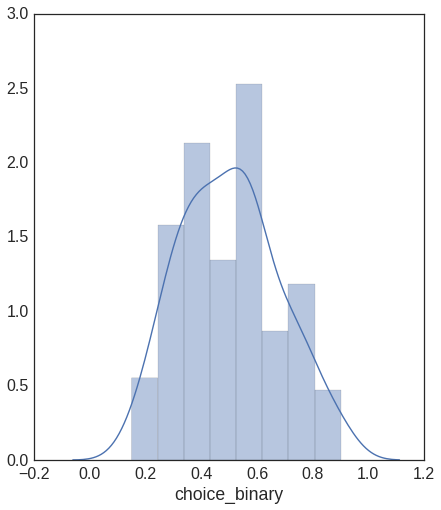

In [261]:
sns.distplot(perc_df['choice_binary'])

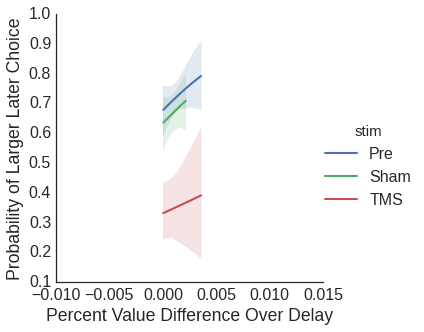

In [302]:
a = all_data.reset_index()
a['diff'] = (a['amountLL'] - a['amountSS'])/a['amountSS']
a['choice_LL'] = [int(not x) for x in a['choice_binary']]
a = a[a['cond'] == 'Magnitude']
sns.lmplot(x = 'k_eq', y = 'choice_LL', hue  = 'stim', logistic = True, 
           truncate  = True, units = 'sub', scatter = False, data = a)
plt.ylabel('Probability of Larger Later Choice')
plt.xlabel('Percent Value Difference Over Delay')